In [1]:
import sys # for gioia to load aiohttp
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [2]:
# to import modules locally without having installed the entire package
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

# Stock Market Similarity Searches: Daily Prices

We have provided a year of daily closing prices for 379 S&P 500 stocks. We have explicitly excluded stocks with incomplete or missing data.

Data source: <a href='www.stockwiz.com'>www.stockwiz.com</a>

### Database Initialization

Let's start by initializing all the database components.

In [4]:
# 1. load the database server

# when running from the terminal
# python go_server.py

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server.py'])

# 2. load the database webserver

# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])

# 3. import the web interface and initialize it

from webserver import *
web_interface = WebInterface()

Generating LALR tables


### Stock Data Initialization

Now that the database is up and running, let's import the `timeseries` package and load the stock data. We will exclude a few stocks, which we will use later in our similarity searches.

In [5]:
from timeseries import *

# load data
with open('data/prices.json') as f:    
    stock_data = json.load(f)
    
# keep track of the stock tickers
stocks = sorted(list(stock_data.keys()))
num_stocks = len(stocks)

# check the number of market days in the year
num_days = len(stock_data[stocks[0]])

# randomly pick stocks to exclude - we'll use these for similarity searches
stocks_exclude = np.random.choice(stocks, size=29, replace=False)
stocks_include = [s for s in stocks if s not in stocks_exclude]

# insert into database
for stock in stocks_include:
    web_interface.insert_ts(pk=stock, ts=TimeSeries(range(num_days), stock_data[stock]))

Let's look at the first 10 stocks, to check that the data has been inserted correctly.

In [6]:
# let's look at the first 10 stocks
web_interface.select(fields=[], additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('A', OrderedDict([('pk', 'A')])),
             ('AA', OrderedDict([('pk', 'AA')])),
             ('ABC', OrderedDict([('pk', 'ABC')])),
             ('ABT', OrderedDict([('pk', 'ABT')])),
             ('ADI', OrderedDict([('pk', 'ADI')])),
             ('ADM', OrderedDict([('pk', 'ADM')])),
             ('AEE', OrderedDict([('pk', 'AEE')])),
             ('AEP', OrderedDict([('pk', 'AEP')])),
             ('AES', OrderedDict([('pk', 'AES')])),
             ('AET', OrderedDict([('pk', 'AET')]))])

### Vantage Point Search

We need to initialize vantage points in order to carry out a vantage point search. Let's randomly pick 30 of the 379 stocks as vantage points, and mark them in the database.

In [7]:
# randomly pick vantage points
num_vps = 30
random_vps = np.random.choice(range(num_stocks), size=num_vps, replace=False)
vpkeys = [stocks[s] for s in random_vps if stocks[s] in stocks_include]

# mark in database
for vp in vpkeys:
    web_interface.insert_vp(vp)

Let's pick a random stock and carry out a vantage point similarity search.

Stock: TXT
Most similar stock: RL


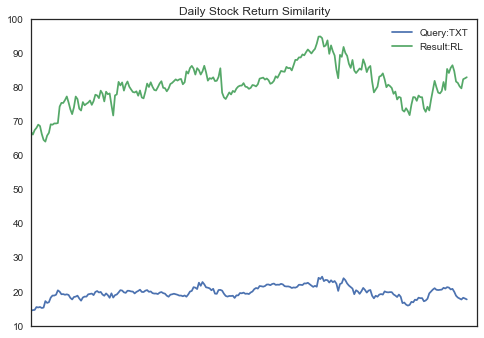

In [8]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data[stock]), 1)
print('Most similar stock:', list(result)[0])

# visualize similarity
plt.plot(stock_data[stock], label='Query:' + stock)
plt.plot(stock_data[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Return Similarity')
plt.show()

### iSAX Tree Search

Let's pick a random stock to carry out an iSAX tree similarity search. Note that this is an approximate search technique, so it will not always be able to find a similar stock.

Stock: APA
Most similar stock: NBL


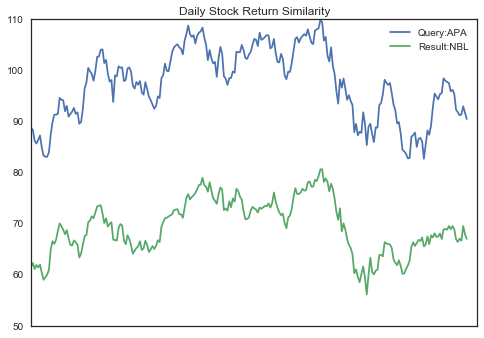

In [10]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the isax tree similarity search
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data[stock]))

# could not find a match
if result == 'ERROR: NO_MATCH':
    print('Could not find a similar stock.')

# found a match
else:
    print('Most similar stock:', list(result)[0])
    
    # visualize similarity
    plt.plot(stock_data[stock], label='Query:' + stock)
    plt.plot(stock_data[list(result)[0]], label='Result:' + list(result)[0])
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Daily Stock Return Similarity')
    plt.show()

### Comparing Similarity Searches

Let's pick another random stock, carry out both types of similarity searches, and compare the results.

Stock: BTU
VP search result: HAL
iSAX search result: LLY


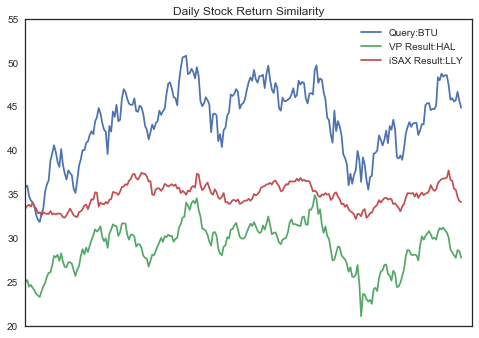

In [11]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result_vp = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data[stock]), 1)
print('VP search result:', list(result_vp)[0])

# run the isax similarity search
result_isax = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data[stock]))

# could not find an isax match
if result_isax == 'ERROR: NO_MATCH':
    print('iSAX search result: Could not find a similar stock.')

# found a match
else:
    print('iSAX search result:', list(result_isax)[0])
    
    # visualize similarity
    plt.plot(stock_data[stock], label='Query:' + stock)
    plt.plot(stock_data[list(result_vp)[0]], label='VP Result:' + list(result_vp)[0])
    plt.plot(stock_data[list(result_isax)[0]], label='iSAX Result:' + list(result_isax)[0])
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Daily Stock Return Similarity')
    plt.show()

### iSAX Tree Representation

Finally, let's visualize the iSAX tree. The clusters represent groups of "similar" stocks.

In [12]:
print(web_interface.isax_tree())

root
--->['11', '10', '00', '10']: 0 []
------>['110', '100', '000', '100']: 4 ['A', 'JCI', 'JWN', 'PKI']
------>['110', '101', '000', '100']: 1 ['CCL']
------>['110', '101', '000', '101']: 1 ['LMT']
------>['110', '100', '000', '101']: 1 ['USB']
--->['01', '00', '01', '11']: 0 []
------>['011', '001', '010', '111']: 5 ['AA', 'AKS', 'CF', 'CSC', 'KG']
------>['010', '001', '011', '111']: 2 ['BAX', 'NOV']
------>['011', '000', '011', '111']: 1 ['PFE']
--->['11', '10', '01', '00']: 0 []
------>['111', '100', '010', '001']: 5 ['ABC', 'D', 'EOG', 'RHT', 'WEC']
------>['111', '101', '010', '000']: 2 ['AVB', 'TIE']
------>['110', '101', '011', '000']: 2 ['AZO', 'NEM']
------>['111', '101', '010', '001']: 5 ['BF.B', 'CPB', 'MCD', 'PXD', 'VTR']
------>['110', '101', '010', '001']: 0 []
--------->['1100', '1010', '0101', '0011']: 1 ['BLL']
--------->['1101', '1010', '0100', '0011']: 1 ['CAT']
--------->['1101', '1011', '0100', '0010']: 1 ['EMC']
--------->['1101', '1010', '0101', '0010']: 3 ['H

### Termination

Always remember to terminate any outstanding processes!

In [13]:
server.terminate()
webserver.terminate()
web_interface = None